# Summary

Determine if exponential decay weighting is better than static weighting for calculating weights for 1st, 2nd and 3rd place statistics.

# Findings

It is more correlated with placing in current race (depending on the decay factor, which should be a hyperparameter).

In [1]:
import os
import re
import tempfile
import warnings

import japanize_matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from JapanHorseRaceAnalytics.utilities.base import (
    get_base_dir,
    get_spark_session,
    read_hive_table,
)
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_payout_rate,
    kelly_criterion,
)
from JapanHorseRaceAnalytics.utilities.mlflow import no_progress_loss
from JapanHorseRaceAnalytics.utilities.plot import (
    plot_confusion_matrix,
    plot_feature_importances,
    plot_roc_curve,
)
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

# Set pandas display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)

# Set seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42


shap.initjs()
japanize_matplotlib.japanize()

In [2]:
spark = get_spark_session()

data = read_hive_table(
    table_name="features_20240304_v1",
    schema="jhra_curated",
    spark_session=spark,
    # use_cache=False,
    parse_dates=["meta_発走日時"],
)

rows_before = data.shape[0]
logger.info(f"Original data length: {rows_before}")

# drop from data where cat_トラック種別 == "障害"
data = data[(data["cat_トラック種別"] != "障害")]

# drop from data where meta_int_race_horses_異常区分 != '0'
data = data[(data["meta_int_race_horses_異常区分"] == "0")]

# keep only horses that have 3 races
data = data[
    (data["num_1走前着順"].notnull())
    & (data["num_2走前着順"].notnull())
    & (data["num_3走前着順"].notnull())
]

rows_after = data.shape[0]
logger.info(
    f"Data length after filtering: {rows_after} (dropped {rows_before - rows_after} rows, {100 * (rows_before - rows_after) / rows_before:.2f}%)"
)

data.reset_index(drop=True, inplace=True)
data.head()

24/03/08 08:55:19 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/03/08 08:55:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/03/08 08:55:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240304_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-03-07T23:55:20.244911Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Original data length: 1108166", "level": "info", "timestamp": "2024-03-07T23:55:20.452529Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Data length after filtering: 752305 (dropped 355861 rows,

,meta_レースキー,meta_馬番,meta_着順,meta_発走日時,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_race_horses_異常区分,meta_実績複勝オッズ,cat_トラック種別,num_休養日数,num_過去3走重み付き着順成績,num_複勝率,num_1走前着順,num_2走前着順,num_3走前着順,num_入厩何日前,num_1走前経過日数,num_2走前経過日数,num_3走前経過日数,num_4走前経過日数,num_5走前経過日数,num_頭数,num_1走前頭数,num_2走前頭数,num_3走前頭数,num_入厩何日前逆数,cat_堅実な馬,cat_訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり
0,01011102,01,5.0,2001-08-04 10:15:00+09:00,51.0,False,0,False,0,0,2.9,ダート,14.0,0.174604,0.250000,7.0,8.0,2.0,NaN,14.0,20.0,34.0,41.0,NaN,12,11.0,13.0,10.0,1.0,False,False,True,False
1,01011102,05,4.0,2001-08-04 10:15:00+09:00,77.0,False,0,False,0,0,1.1,ダート,14.0,0.077879,0.333333,4.0,3.0,4.0,NaN,14.0,42.0,62.0,NaN,NaN,12,14.0,16.0,16.0,1.0,False,False,False,False
2,01011107,07,5.0,2001-08-04 13:15:00+09:00,75.0,False,0,False,0,0,2.0,ダート,21.0,0.004530,1.000000,1.0,2.0,3.0,NaN,21.0,41.0,56.0,NaN,NaN,13,14.0,13.0,13.0,1.0,False,False,False,False
3,01011110,01,9.0,2001-08-04 14:55:00+09:00,0.0,False,0,False,0,0,10.4,芝,21.0,0.207357,0.333333,10.0,6.0,1.0,NaN,21.0,34.0,56.0,NaN,NaN,9,13.0,13.0,13.0,1.0,False,False,True,False
4,01011111,13,8.0,2001-08-04 15:30:00+09:00,0.0,False,0,False,0,0,10.2,ダート,21.0,0.134168,0.333333,7.0,8.0,1.0,NaN,21.0,34.0,49.0,NaN,NaN,13,13.0,13.0,13.0,1.0,False,False,True,False


In [3]:
decay_rate = 0.0075

df = data.copy()

df["num_標準着順"] = (df["meta_着順"] - 1) / (df["num_頭数"] - 1)
df["num_1走前標準着順"] = (df["num_1走前着順"] - 1) / (df["num_1走前頭数"] - 1)
df["num_2走前標準着順"] = (df["num_2走前着順"] - 1) / (df["num_2走前頭数"] - 1)
df["num_3走前標準着順"] = (df["num_3走前着順"] - 1) / (df["num_3走前頭数"] - 1)

# We want our factor (num_1走前経過日数) to start from 0, so subtract the minimum value for "days since last race" across all horses
df["num_1走前重み"] = np.exp(
    -decay_rate * df["num_1走前経過日数"] - df["num_1走前経過日数"].min()
)
df["num_2走前重み"] = np.exp(
    -decay_rate * df["num_2走前経過日数"] - df["num_1走前経過日数"].min()
)
df["num_3走前重み"] = np.exp(
    -decay_rate * df["num_3走前経過日数"] - df["num_1走前経過日数"].min()
)

df["num_1走前重み付き標準着順"] = df["num_1走前標準着順"] * df["num_1走前重み"]
df["num_2走前重み付き標準着順"] = df["num_2走前標準着順"] * df["num_2走前重み"]
df["num_3走前重み付き標準着順"] = df["num_3走前標準着順"] * df["num_3走前重み"]

# Calculate weighted average of the feature
# weighted_feature_values = np.average([value for _, value in races], weights=weights)
df["weighted_着順"] = (
    df["num_1走前重み付き標準着順"]
    + df["num_2走前重み付き標準着順"]
    + df["num_3走前重み付き標準着順"]
) / (df["num_1走前重み"] + df["num_2走前重み"] + df["num_3走前重み"])


# This is looking OK, now just check how it correlates with the race outcome

df[
    [
        "num_1走前着順",
        "num_1走前頭数",
        "num_1走前標準着順",
        "num_1走前経過日数",
        "num_1走前重み",
        "num_1走前重み付き標準着順",
        "num_2走前着順",
        "num_2走前標準着順",
        "num_2走前経過日数",
        "num_2走前重み",
        "num_2走前重み付き標準着順",
        "num_3走前着順",
        "num_3走前標準着順",
        "num_3走前経過日数",
        "num_3走前重み",
        "num_3走前重み付き標準着順",
        "weighted_着順",
    ]
]
# .groupby("num_1走前重み")["num_1走前経過日数"].mean().plot.line(figsize=(20, 3), legend=True)
# .plot.line(figsize=(20, 3))
# .plot.line(x="num_1走前経過日数", y="num_1走前重み")

,num_1走前着順,num_1走前頭数,num_1走前標準着順,num_1走前経過日数,num_1走前重み,num_1走前重み付き標準着順,num_2走前着順,num_2走前標準着順,num_2走前経過日数,num_2走前重み,num_2走前重み付き標準着順,num_3走前着順,num_3走前標準着順,num_3走前経過日数,num_3走前重み,num_3走前重み付き標準着順,weighted_着順
0,7.0,11.0,0.600000,14.0,0.006066,0.003640,8.0,0.583333,20.0,0.005799,0.003383,2.0,0.111111,34.0,0.005221,0.000580,0.444952
1,4.0,14.0,0.230769,14.0,0.006066,0.001400,3.0,0.133333,42.0,0.004917,0.000656,4.0,0.200000,62.0,0.004232,0.000846,0.190723
2,1.0,14.0,0.000000,21.0,0.005756,0.000000,2.0,0.083333,41.0,0.004954,0.000413,3.0,0.166667,56.0,0.004427,0.000738,0.076017
3,10.0,13.0,0.750000,21.0,0.005756,0.004317,6.0,0.416667,34.0,0.005221,0.002176,1.0,0.000000,56.0,0.004427,0.000000,0.421473
4,7.0,13.0,0.500000,21.0,0.005756,0.002878,8.0,0.583333,34.0,0.005221,0.003046,1.0,0.000000,49.0,0.004666,0.000000,0.378683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752300,2.0,16.0,0.066667,8.0,0.006346,0.000423,5.0,0.266667,22.0,0.005713,0.001523,4.0,0.200000,43.0,0.004881,0.000976,0.172537
752301,4.0,16.0,0.200000,8.0,0.006346,0.001269,5.0,0.266667,15.0,0.006021,0.001606,7.0,0.428571,63.0,0.004201,0.001800,0.282184
752302,5.0,16.0,0.266667,8.0,0.006346,0.001692,6.0,0.333333,155.0,0.002107,0.000702,4.0,0.250000,176.0,0.001800,0.000450,0.277441
752303,14.0,16.0,0.866667,113.0,0.002887,0.002502,5.0,0.333333,141.0,0.002340,0.000780,5.0,0.235294,204.0,0.001459,0.000343,0.542229


In [5]:
# Depending on the decay factor, num_過去3走重み付き着順成績 is more correlated with target than num_過去3走重み付き着順成績
df[["weighted_着順", "num_過去3走重み付き着順成績", "meta_複勝的中", "meta_単勝的中"]].corr()

,weighted_着順,num_過去3走重み付き着順成績,meta_複勝的中,meta_単勝的中
weighted_着順,1.000000,0.903139,-0.293159,-0.190960
num_過去3走重み付き着順成績,0.903139,1.000000,-0.276282,-0.178843
meta_複勝的中,-0.293159,-0.276282,1.000000,0.526174
meta_単勝的中,-0.190960,-0.178843,0.526174,1.000000


In [104]:
(df["num_1走前経過日数"] - df["num_1走前経過日数"].min()).describe()

count    752305.000000
mean         45.891852
std          65.193659
min           0.000000
25%          15.000000
50%          23.000000
75%          51.000000
max        2691.000000
Name: num_1走前経過日数, dtype: float64

65.19365907748383

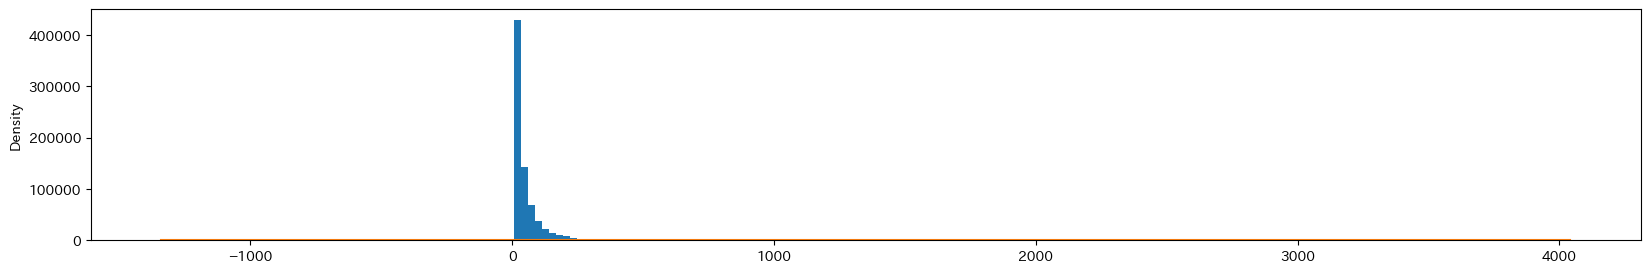

In [96]:
# Visualize the distribution and standard deviation of df["num_1走前経過日数"]
df["num_1走前経過日数"].plot.hist(bins=100, figsize=(20, 3))
df["num_1走前経過日数"].plot.kde(figsize=(20, 3))
df["num_1走前経過日数"].std()

<Axes: xlabel='num_1走前経過日数'>

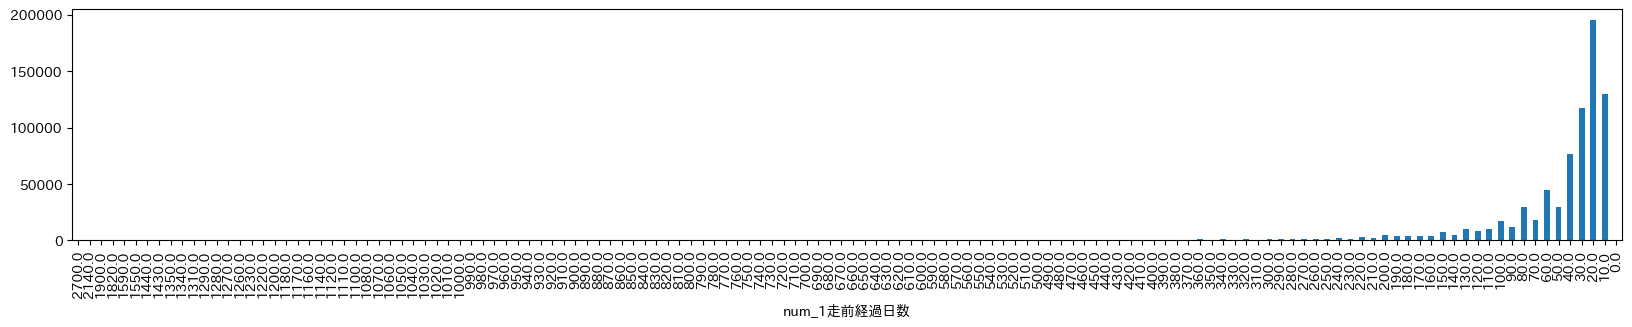

In [97]:
# Round df["num_1走前経過日数"] to the nearest 10
df["num_1走前経過日数"].round(-1).value_counts().sort_index(ascending=False).plot.bar(
    figsize=(20, 3)
)

In [35]:
np.exp(-decay_rate * 5)

0.6065306597126334

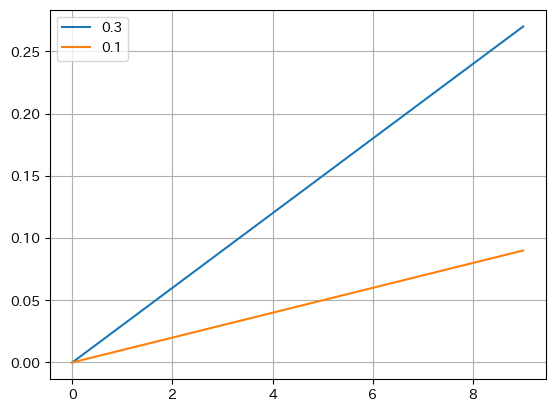

In [14]:
fig, ax = plt.subplots()

ax.plot([pos * 0.3 for pos in np.arange(0, 1, 0.1)], label="0.3")
ax.plot([pos * 0.1 for pos in np.arange(0, 1, 0.1)], label="0.1")

plt.legend()
plt.grid(True)
plt.show()

In [6]:
import numpy as np

# Example data: each entry is (days_since_race, feature_value)
races = [(30, 2), (60, 2.5), (90, 1.8), (120, 2.2)]

decay_rate = 0.1

# Calculate weights using exponential decay
weights = np.exp(-decay_rate * np.array([days_since_race for days_since_race, _ in races]))

# Calculate weighted average of the feature
weighted_feature_values = np.average([value for _, value in races], weights=weights)

print(weighted_feature_values)

2.0232066853262327


In [7]:
weights

array([4.97870684e-02, 2.47875218e-03, 1.23409804e-04, 6.14421235e-06])

In [10]:
np.exp(30 * -0.1)

0.049787068367863944